# Pauli twirled noise learning
This notebook implements the procedure described in section SIV, noise learning for single-qubit gates with crosstalk on a simulated backend

## Imports

In [1]:
from qiskit.circuit.library import HGate, XGate, YGate, ZGate, IGate
from qiskit.providers.fake_provider import FakeLondon
from qiskit.providers.aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate

import numpy as np
from random import choices
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

from abc import ABC, abstractmethod
from typing import Any, List

## Dynamic circuits
I struggled to find a good way to set up the pauli twirl. The solution I came up with was an abtract class called `dynamic_circuit`. This is a combination of the `qiskit.experiments` approach and the mitiq `execute with PEC` approach. This generalizes the need to create distributions of circuits, compile and send them to a backend, and convert the results into estimators.

The utility of a class like this is that functions like pauli twirling and readout twirling can be easily chained together. The problem of sampling circuits can be broken down into multiple parts, with layers of the circuit updating themselves.

The anlysis class of the readout data flips the bit results in classical post-processing for every $X$ that was applied at the end. The analysis class of the twirling procedure does nothing, because the twirled gates ideally compose to the identity. The `learning_procedure` analysis class computes the parity of the overlap with the desired pauli observable $P_{z(i)}$ after the readout analysis is processed and returns $\pm 1$. 

### Helper methods
A few useful methods for later use

In [2]:
#return the composition of two gate objects with
#a name that reflects the two gates that were composed,
#primarily for debugging
def compose_gates(gate1 : Gate, gate2 : Gate) -> Gate:
    qc = QuantumCircuit(1)
    qc.append(gate1, [0])
    qc.append(gate2, [0])
    gate = qc.to_gate()
    gate.name = gate1.name + "."+gate2.name
    return gate

#compose two arrays of gates representing layers together pairwise
def _compose_layers(layer1 : List[Gate], layer2 : List[Gate]) -> List[Gate]:
    return [compose_gates(gate1, gate2) for (gate1, gate2) in zip(layer1, layer2)]

#compose an arbitrary number of layers together pairwise
def compose_layers(*layers : List[Gate]) -> List[Gate]:
    layer = layers[0]
    for i in range(1,len(layers)):
        layer = _compose_layers(layer, layers[i])
    return layer

#append a layer of single-qubit gates represented as an array of gates
#to a QuantumCircuit instance
def append_layer(qc : QuantumCircuit, layer : List[Gate]) -> None:
    for i,gate in enumerate(layer):
        qc.append(gate,[i])

#compute the dot product of two binary strings
def dot_product(binstr1 : str, binstr2 : str) -> int:
    tot = 0
    for char1, char2 in zip(binstr1, binstr2):
        if char1 == '1' and char2 == '1':
            tot += 1
    return tot % 2

#convert a pauli operator to a weight map, e.g. 'XXIZ' -> '1101'
def pauli_to_binstr(pauli : str) -> str:
    binstr = "" 
    for p in pauli:
        if p == 'I':
            binstr += '0'
        else:
            binstr += '1'
    return binstr

### Abstract class Implementation

This is the general dynamic circuit interface that will be used to set up the procedure. The class is intended to be generalizable, and promises to contain the following:
1. A method to sample gates from a distribution and compute the metadata needed for analyzing the result of running the instance
2. A method to convert the gate layers to a usable circuit, such as qiskit or pyquil
3. A method to convert a single shot of the circuit into an estimator based on the metadata associated with the circuit instance

In [3]:
'''
An abstract class for randomly sampling circuits

This class stores
    -  circuit dimension
    -  a method for sampling the circuit
    -  a method for converting to a usable circuit format such as quil or qiskit
    -  a metadata object that gets updated when sampling
'''

class dynamic_circuit(ABC):

    def __init__(self, dim):
        self.metadata = {} #metadata associated with circuit instance
        self.dim = dim #dimension of the resulting circuit
        self.sample() #call the sampling method to start with a random circuit

    #This method samples from a distribution of gates/layers/circuits
    #metadata must be updated by this method
    @abstractmethod
    def sample(self) -> None:
        pass
    
    #Return a usable circuit form from whatever underlying structure such as
    #an array of dynamic_circuit's or an array of gates
    @abstractmethod
    def get_circuit(self) -> Any:
        pass

    '''
    Each circuit object will represent an estimator of some value.
    this method takes the result of a single shot of the circuit and 
    uses the associated metadata to produce a single estimator measurement.

    This method is static, anticipating that the original class instances generating
    the data will not be carried once the circuits are sent for executation. Instead,
    an uninstantiated version of the class can be used, and the metadata needs to
    contain enough information to perform the analysis
    '''
    @staticmethod
    @abstractmethod
    def analyze(result : str, **metadata) -> Any:
        pass
    
    #return a copy of the metadata. One of the most common mistakes I
    #make is not copying arrays and accidentally passing pointers instead of data
    def get_metadata(self) -> dict:
        return self.metadata.copy()

    #set a specific entry in the metadata dictionary
    def set_metadata(self, **metadata) -> None:
        for key in metadata:
            self.metadata[key] = metadata[key]

### Dynamic circuit representing layer of twirling

In [4]:
#Implement a single layer of pauli-twirled noise
class twirled_layer(dynamic_circuit):
    #...  original constructor

    #implement sampling routine
    def sample(self):
        self.layers = [None]*2
        #choose random paulis for each qubit
        self.layers[0] = choices([IGate(), XGate(), YGate(), ZGate()], k = self.dim)
        #paulis are hermitian, so repeat the layer for the twirl
        self.layers[1] = self.layers[0].copy()
    
    #return a circuit object looking like --P_i--P_i--
    def get_circuit(self):
        qc = QuantumCircuit(self.dim)
        for i,gate in enumerate(self.layers[0]):
            qc.append(gate,[i])
        for i,gate in enumerate(self.layers[1]):
            qc.append(gate,[i])
        return qc

    #No analysis needed because overall unitary is identity
    @staticmethod
    def analyze(result : str, **metadata) -> str:
        return result

### Dynamic circuit representing noise-twirled readout
readout-twirling described in this paper: https://arxiv.org/abs/2012.09738 . The scheme is that before readout, gates are randomly samples from $\{I, X\}$ on each qubit. This diagonalizes the readout error in the Z basis, and allows for efficient characterization of spam errors.

In [5]:
class readout_layer(dynamic_circuit):
    #... same constructor

    #randomly sample from {I,X}^\otimes dim
    def sample(self) -> None:
        flips = choices(['0','1'], k=self.dim) #randomly choose flips
        self.layer = [None]*self.dim
        self.layer = [{'0':IGate(), '1':XGate()}[bit] for bit in flips] #create gate layer
        self.set_metadata(readout_flip = "".join(flips)) #record flip sequence as metadata

    #return a circuit like --I-- or --X-- for each qubit
    def get_circuit(self) -> QuantumCircuit:
        qc = QuantumCircuit(self.dim)
        append_layer(qc, self.layer)

        return qc

    #take flip the result if an 'X' was applied to the bit 
    @staticmethod
    def analyze(result, **metadata) -> str:
        #get binary string representing where 'X' was applied
        ro_string = metadata['readout_flip']
        return 1-2*(ro_string.count('1')%2)

### Noise learning for single-qubit gates with crosstalk

Here, the `learning_procedure` class implements the single qubit learning procedure as described in section SIV of the paper:

1. Gates $B_i$ implement a basis change from $P_{z(i)}$ to $P_i$ in the first layer
2. Conjugate pairs of pauli gates are randomly sampled into $2k$ layers to twirl the noise
3. The gates $B_i^\dagger$ are inserted in the penultimate layer to convert back to the $P_{z(i)}$ basis
4. Gates on each qubit are randomly sampled from $\{I, X\}$ to diagonalize the readout error, so it becomes classical readout error
5. The gates from each layer are composed together into $k+1$ layers of unitaries, resulting in $k+1$ applications of noise, with the $k+1$ term counting as readout error.


In [6]:
#define H*S gate
qc = QuantumCircuit(1)
qc.h(0)
qc.s(0)
HS = qc.to_gate()
HS.name = 'HS'

#define S^dag * H gate
qc = QuantumCircuit(1)
qc.sdg(0)
qc.h(0)
SDGH = qc.to_gate()
SDGH.name = 'SdagH'

#convert P_z(i) basis to P_i and back for single qubits
BASIS_CHANGE = {'I':IGate(), 'Z':IGate(), 'X':HGate(), 'Y':HS}
BASIS_CHANGE_BACK = {'I':IGate(), 'Z':IGate(), 'X':HGate(), 'Y':SDGH}

#class representing the full single-qubit gate with crosstalk learning procedure
class learning_procedure(dynamic_circuit):

    #paulis P_p and P_m are used to compute 1/2**n Tr(P_m Lambda(P_p))
    #The layers containing the basis change are static circuit layers,
    #The noise twirling and readout twirling are implemented as dynamic circuits

    def __init__(self, pauli_prep : str, pauli_meas : str, eigenstate : str, k : int, dim : int):
        # must have k > 0. in particular, if k==0 then there are no longer k+1 cycles of noise
        # this is taken care of by the first term in the exponential fit
        if k < 1:
            raise Exception("k must be > 0")

        #initialize class variables used in circuit conversion and sampling
        self.k = k
        self.pauli_prep = pauli_prep
        self.pauli_meas = pauli_meas
        self.eigenstate = eigenstate

        #implement static and dynamic circuit layers
        self.prep_layer = [{'0':IGate(), '1':XGate()}[sgn] for sgn in eigenstate]
        self.B_layer = [BASIS_CHANGE[p] for p in pauli_prep]
        self.twirled_layers = [twirled_layer(dim) for i in range(k)]
        self.B_dag_layer = [BASIS_CHANGE_BACK[p] for p in pauli_meas]
        self.ro_layer = readout_layer(dim)

        super().__init__(dim) #initialize implemented class

        self.sample() #generate random circuit layers
        #set metadata
        self.set_metadata(pauli_prep = pauli_prep, 
                          pauli_meas = pauli_meas,
                          eigenval = 1-2*(eigenstate.count('1') % 2),
                          k = k)

    #sample from twirled and readout layers
    def sample(self) -> None:
        for layer in self.twirled_layers:
            layer.sample()
        self.ro_layer.sample()
        self.set_metadata(**self.ro_layer.get_metadata())

    #for debugging purposes, return circuit before unitaries are combined
    def get_raw_circuit(self) -> QuantumCircuit:
        qc = QuantumCircuit(self.dim)
        #append eigenstate prep layer
        append_layer(qc, self.prep_layer)
        #append b layer
        append_layer(qc, self.B_layer)
        qc.barrier()
        #append twirling layers with barriers in between
        for twirled_layer in self.twirled_layers:
            for layer in twirled_layer.layers:
                append_layer(qc, layer)
            qc.barrier()
        #append bdag layer
        append_layer(qc, self.B_dag_layer)
        #append readout twirling layer
        append_layer(qc, self.ro_layer.layer)

        return qc

    #Combine unitaries so that the noise is applied k+1 times during execution
    def get_circuit(self):
        qc = QuantumCircuit(self.dim)
        #compose B layer with first half of first layer of twirling
        append_layer(qc, compose_layers(self.prep_layer,
                                        self.B_layer, 
                                        self.twirled_layers[0].layers[0]))
        qc.barrier()

        #combine the second half of each twirled layer with the first half of the next one
        for i in range(1,self.k):
            append_layer(qc, 
                         compose_layers(self.twirled_layers[i-1].layers[1],
                                        self.twirled_layers[i].layers[0]))
            qc.barrier()
        
        #compose last half of last layer of twirl with basis change layer and readout layer
        append_layer(qc, compose_layers(self.twirled_layers[-1].layers[1], 
                                self.B_dag_layer, 
                                self.ro_layer.layer))
        return qc

    #Analyze readout twirling and compute overlap with desired pauli
    @staticmethod
    def analyze(result, **metadata):
        #get the pauli observable that is being measured
        pauli_meas = metadata['pauli_meas']
        #call the readout class analysis on result to untwirl the readout
        readout_mitigation = readout_layer.analyze(result, **metadata)
        tot = dot_product(result, pauli_to_binstr(pauli_meas))
        #find parity and return as \pm 1
        return (1-2*tot)*readout_mitigation*metadata['eigenval']

### Brief demo
a demo of the `learning_procedure` class

In [7]:
example_procedure = learning_procedure("XYX", "XYX", '00', 2, 3) #sample() is called in the constructor
example_procedure.get_raw_circuit().draw() #a different circuit will be generated each time

┌───┐┌───┐  ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░   ┌───┐  ┌───┐
q_0: ┤ I ├┤ H ├──░─┤ Z ├┤ Z ├─░─┤ Z ├┤ Z ├─░───┤ H ├──┤ I ├
     ├───┤├───┴┐ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ┌─┴───┴─┐├───┤
q_1: ┤ I ├┤ HS ├─░─┤ I ├┤ I ├─░─┤ Z ├┤ Z ├─░─┤ SdagH ├┤ X ├
     ├───┤└────┘ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ └─┬───┬─┘├───┤
q_2: ┤ H ├───────░─┤ Z ├┤ Z ├─░─┤ Y ├┤ Y ├─░───┤ H ├──┤ X ├
     └───┘       ░ └───┘└───┘ ░ └───┘└───┘ ░   └───┘  └───┘

In [8]:
print(example_procedure.get_metadata()) #this will reflect the structure of the above circuit

{'readout_flip': '011', 'pauli_prep': 'XYX', 'pauli_meas': 'XYX', 'eigenval': 1, 'k': 2}


In [9]:
#noise is applied after every layer. There are k+1 layers for k > 1
example_procedure.get_circuit().draw()

┌────────┐  ░ ┌─────┐  ░   ┌────────┐ 
q_0: ─┤ id.h.z ├──░─┤ z.z ├──░───┤ z.h.id ├─
     ┌┴────────┴┐ ░ ├─────┴┐ ░ ┌─┴────────┴┐
q_1: ┤ id.HS.id ├─░─┤ id.z ├─░─┤ z.SdagH.x ├
     └──────────┘ ░ ├─────┬┘ ░ └─┬───────┬─┘
q_2: ─────────────░─┤ z.y ├──░───┤ y.h.x ├──
                  ░ └─────┘  ░   └───────┘

## Measurement procedure

The measurement procedure involves measuring $\text{Tr}[P_a \Lambda^k(P_a)]$ for different depths $k$. Then, an exponential of the form $ae^{-bx}$ is fit to the data, noting that $\text{Tr}[P_a \Lambda^{k\to\infty}(P_a)] = \text{Tr}[P_aI] = 0$. The $a$ coefficient gives the strength of the SPAM noise, and $e^{-b}$ gives the fidelity $f_a$. 

In order to later run this on a Rigetti processor, the process is broken up into different parts.
1. The circuits are sampled randomly and transpiled, then recorded with the corresponding metadata
2. The transpiled circuits are run on the backend (in this case `FakeLondon`) and results are recorded with the metadata
3. The analysis method of the `learning procedure` class is used to produce the estimator values, then the valus are averaged

### Helper methods
A routine to generate benchmark paulis and display a progress bar.

The paper mentions that the measurements can be combined into a basis of only nine measurements. I have not learned how to do this yet.

In [10]:
#generate all of the paulis with support on connected qubit pairs and on the single qubits
def generate_paulis(adjacency_list : List[tuple], proc_size : int) -> List[str]:
    pauli_list = []
    idPauli = ['I']*proc_size
    
    #get all single-weight paulis
    for i in range(proc_size):
        for op in ['X','Y','Z']:
            pauli = idPauli.copy()
            pauli[i] = op
            pauli_list.append("".join(pauli))

    #get all weight-two paulis on nieghboring qubits
    for (qubit1, qubit2) in adjacency_list:
        for pauli1, pauli2 in product(['X','Y','Z'], repeat =2):
            pauli = idPauli.copy()
            pauli[qubit1] = pauli1
            pauli[qubit2] = pauli2
            pauli_list.append("".join(pauli))

    return pauli_list

# Displays a nice progress bar
def progressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

#this is what the generate_paulis method does
#size is 3n+9(n-1)
print(generate_paulis([(0,1),(1,2),(2,3)], 4))

['XIII', 'YIII', 'ZIII', 'IXII', 'IYII', 'IZII', 'IIXI', 'IIYI', 'IIZI', 'IIIX', 'IIIY', 'IIIZ', 'XXII', 'XYII', 'XZII', 'YXII', 'YYII', 'YZII', 'ZXII', 'ZYII', 'ZZII', 'IXXI', 'IXYI', 'IXZI', 'IYXI', 'IYYI', 'IYZI', 'IZXI', 'IZYI', 'IZZI', 'IIXX', 'IIXY', 'IIXZ', 'IIYX', 'IIYY', 'IIYZ', 'IIZX', 'IIZY', 'IIZZ']


### Single measurement at one depth
Making a single fidelity measurement at a single depth before moving to the full procedure

In [11]:
small_proc = [(0,1)] #set up a two-qubit processor
pauli_set = generate_paulis(small_proc,2) #generate benchmark paulis
num = len(pauli_set)
sglp = learning_procedure("XX", "XY", '00',2, 2)
print(pauli_set)

['XI', 'YI', 'ZI', 'IX', 'IY', 'IZ', 'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']


Example of the effect of transpilation. One problem I have encountered is that in the unlikely event that the gate $I \circ I$ is encountered, the transpiler completely gets rid of the layer. I would like to figure out how to replace these with delays.

In [12]:
sglp.get_circuit().draw()

┌────────┐ ░ ┌─────┐  ░   ┌────────┐  
q_0: ┤ id.h.x ├─░─┤ x.x ├──░───┤ x.h.id ├──
     ├────────┤ ░ ├─────┴┐ ░ ┌─┴────────┴─┐
q_1: ┤ id.h.x ├─░─┤ x.id ├─░─┤ id.SdagH.x ├
     └────────┘ ░ └──────┘ ░ └────────────┘

In [13]:
london = FakeLondon()
backend = AerSimulator.from_backend(london)
transpile(sglp.get_circuit(), backend, optimization_level=0).draw()

┌───┐┌─────────┐┌───────────┐ ░ ┌───────────┐┌───────────┐ ░ »
      q_0 -> 0 ┤ I ├┤ U2(0,π) ├┤ U3(π,0,π) ├─░─┤ U3(π,0,π) ├┤ U3(π,0,π) ├─░─»
               ├───┤├─────────┤├───────────┤ ░ ├───────────┤└───┬───┬───┘ ░ »
      q_1 -> 1 ┤ I ├┤ U2(0,π) ├┤ U3(π,0,π) ├─░─┤ U3(π,0,π) ├────┤ I ├─────░─»
               └───┘└─────────┘└───────────┘ ░ └───────────┘    └───┘     ░ »
ancilla_0 -> 2 ─────────────────────────────────────────────────────────────»
                                                                            »
ancilla_1 -> 3 ─────────────────────────────────────────────────────────────»
                                                                            »
ancilla_2 -> 4 ─────────────────────────────────────────────────────────────»
                                                                            »
«               ┌───────────┐┌─────────┐    ┌───┐                
«      q_0 -> 0 ┤ U3(π,0,π) ├┤ U2(0,π) ├────┤ I ├────────────────
«               └───┬───┬───┘├─────────┴┐┌──┴───┴──┐┌───────────┐
«      q_1 -> 1 ────┤ I ├────┤ U1(-π/2) ├┤ U2(0,π) ├┤ U3(π,0,π) ├
«                   └───┘    └──────────┘└─────────┘└───────────┘
«ancilla_0 -> 2 ─────────────────────────────────────────────────
«                                                                
«ancilla_1 -> 3 ─────────────────────────────────────────────────
«                                                                
«ancilla_2 -> 4 ─────────────────────────────────────────────────
«

In [14]:
shots = 1000 #shots of estimator to take
transpiled_circs = [] #stores tuples of transpiled circuits and metadata
for j,binstr in enumerate(product('01', repeat = 2)):
    sglp = learning_procedure("XX","XX", "".join(binstr), 2, 2)
    for i in range(shots):
        sglp.sample() #generate a random circuit
        #measure the qubits in the circuit
        qc = sglp.get_circuit()
        qc.measure_all()
        #transpile the circuit and store with metadata
        circ = transpile(qc, backend)
        transpiled_circs.append((circ, sglp.get_metadata()))
        progressBar(j*shots+i+1, shots*2**2)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [15]:
results = [] #store tuples containing results and metadata

for i,(circ, metadata) in enumerate(transpiled_circs):
    #get result
    res = backend.run(circ, shots = 1).result().get_counts()
    #get result of single shot (is there a better way?)
    count = list(res.keys())[0]
    results.append((count, metadata))
    progressBar(i+1, shots*2**2)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [16]:
total = 0
for result, metadata in results:
    total += learning_procedure.analyze(result, **metadata)

print(total/shots/2**2)

0.841


### Measurements at multiple depths
Taking measurements at multiple depths and fitting the exponentials

In [17]:
n = 2
depths = [2,4,8,16,32]
shots = 1000
num_circuits = shots*len(depths)*2**n
print("Creating", num_circuits, "circuit instances")

instances = []
for k in depths:
    for j,binstr in enumerate(product('01', repeat = n)):
        sglp = learning_procedure("XX","XX", "".join(binstr), k, n)
        for i in range(shots):
            sglp.sample()
            qc = sglp.get_circuit()
            qc.measure_all()
            instances.append((qc, sglp.get_metadata()))
            progressBar(depths.index(k)*shots*2**n+shots*j+i+1, num_circuits)

Creating 20000 circuit instances
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [18]:
transpiled_circs = []

for i,(circ, metadata) in enumerate(instances):
    transpiled_circs.append((transpile(circ, backend, optimization_level = 0), metadata))
    progressBar(i+1, num_circuits)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [19]:
results = []
for i,(circ, metadata) in enumerate(transpiled_circs):
    result = backend.run(circ, shots = 1).result().get_counts()
    count = list(result.keys())[0]
    results.append((count, metadata))
    progressBar(i+1, num_circuits)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [20]:
values = dict(zip(depths, np.zeros([len(depths)])))
for result, metadata in results:
    expec = learning_procedure.analyze(result, **metadata)
    values[metadata['k']] += expec/shots/2**n

In [21]:
popt, pcov = curve_fit(lambda x,a,b,c : a*np.exp(-b*x)+c, depths, list(values.values()), p0=[.95, .15, .3])

(0.0, 1.0)

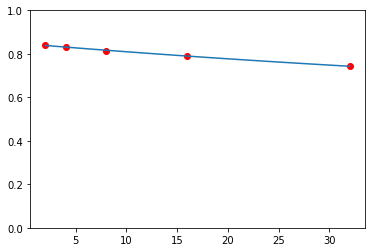

In [23]:
yrange = list(values.values())
xrange = np.linspace(np.min(depths), np.max(depths))
plt.plot(depths, yrange, 'ro')
plt.plot(xrange, popt[0]*np.exp(-popt[1]*xrange)+popt[2])
plt.ylim([0,1])

In [24]:
popt[2]

0.5162147299236424